# Working with large virtual chemical libraries: Part 3 - Thompson Sampling for Classification

---

Only about 18 months after I wrote the first one, this is part 3 of a three post series on working with large chemical libraries. The notebook used to create this post and all the files can be found in this [github repo](https://github.com/jonswain/TS-for-classification).

The first post in this series on active learning can be [found here](https://jonswain.github.io/active%20learning/ai/cheminformatics/data%20science/machine%20learning/ultra-large%20libraries/2024/05/18/ultra-large-libraries-part-1.html).

The second post in this series on genetic algorithms can be [found here](https://jonswain.github.io/ai/cheminformatics/data%20science/genetic%20algorithms/ultra-large%20libraries/2025/01/02/ultra-large-libraries-part-2.html).

---

## Chemical space and combinatorial libraries

In the first two parts of this series, I've discussed how chemical space is vast. The estimates of the size of theoretical chemical space, ranging from $10^{50}$ to $10^{80}$ possible compounds, vastly exceeds our practical screening capabilities, even when constrained to commercial combinatorial libraries like Enamine REAL, which contains tens of billions of compounds. As previously mentioned, even with a fast scoring function of one second per compound, exhaustively screening a billion-compound library would take over 31 years. This fundamental limitation necessitates the use of intelligent search strategies to efficiently navigate and identify active molecules within these immense virtual spaces.

## Thompson Sampling

This whole series was inspired by a paper on searching ultra-large chemical spaces using Thompson Sampling by Pat Walters et al., ["Thompson Sampling─An Efficient Method for Searching Ultralarge Synthesis on Demand Databases"](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01790).

[Thompson Sampling](https://en.wikipedia.org/wiki/Thompson_sampling) is a powerful reinforcement learning technique used to address the ["multi-armed bandit problem"](https://en.wikipedia.org/wiki/Multi-armed_bandit). In the multi-armed bandit problem, a gambler must choose which of a row of slot machines (multi-armed bandits) to play, aiming to maximize total returns by finding the most rewarding machine. This requires balancing exploration (testing all machines to estimate their true return rate) and exploitation (playing the machine currently believed to be the best).

Thompson Sampling aims to maximize returns by modeling a **posterior belief distribution** (the probability distribution of potential rewards) for each slot machine. This is usually initially generated by random sampling to build up a distribution. During each round of Thompson Sampling, for each machine, a value is randomly sampled from its posterior belief distribution, and the machine with the highest sampled value is selected for the next trial (the arm on the slot machine is pulled). The outcome (reward) from that trial is then used to update the machine's belief distribution, making it more accurate. The randomness associated from sampling the belief distribution for each machine allows exploration of the returns for each machine, but because the machines with genuinely higher returns will have distributions that generally return higher numbers when sampled, they are trialed more frequently, allowing for sufficient exploitation. 

### Thompson Sampling for virtual chemistry screening

In the paper by Walters et al., the "slot machines" are the individual building blocks used in a virtual reaction. These blocks are combined to form a virtual molecule, which is then assessed using a scoring function (the "reward"). Each building block has a belief distribution for the scores associated with compounds containing it, which is updated after the compound is scored.

The authors are seeking to maximize a continuous scoring function. They modeled the reward distribution using a Normal distribution $\mathcal{N}(\mu, \sigma^2)$ with mean $\mu$ and standard deviation $\sigma$:
$$X \sim \mathcal{N}(\mu, \sigma^2)$$

After each trial, a Bayesian update was performed on the parameters ($\mu$ and $\sigma$) of the belief distribution for each building block found in the scored compound. Using this method, the authors showed that Thompson Sampling could identify more than half of the top 100 molecules from a docking-based virtual screen of 335 million molecules by evaluating just 1% of the data set.

## Thompson Sampling for classification

What if we've built a classification machine learning model to predict compound activity (Active=1, Inactive=0), but we're not able to exhaustatively screen the entire library, can we use Thompson Sampling to find active compounds from our library? We can no longer model our reward distributions using the Normal distribution, as our activity labels are just 0 or 1, and we can't have values greater than 1 or less than 0. Instead we need to use the [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution).

The underlying event when scoring each compound is a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial), returning either a success (1) or a failure (0), so we can use the Bernoulli distribution to model the probability the compound containing the building block is active with probability $p$. For the Bayesian statistics required for Thompson Samping, we need to model the uncertainty about $p$. The Beta distribution is the **conjugate prior probability distribution** for the Bernoulli distribution, making it the perfect choice to model the uncertainty about $p$. The Beta distribution is a family of continuous probability distributions defined between 0 and 1, defined by two parameters: alpha ($\alpha$) and beta ($\beta$). Alpha is related to the number of successes (active compounds), and beta to the number of failures (inactive compounds) in the Bernoulli trials.

Traditionally, $\alpha$ is updated by adding 1 for a success, and $\beta$ is updated by adding 1 for a failure. However, since a classification ML model provides a probability prediction ($P_{\text{pred}}$), we can use a more informative soft-update approach: we sum $P_{\text{pred}}$ for $\alpha$ (representing partial success evidence), and sum $1 - P_{\text{pred}}$ for $\beta$ (representing partial failure evidence).

## Data and machine learning classification model

As with all the other posts in this series, the smi files used here were borrowed from Pat Walters repository on [Thompson sampling](https://github.com/PatWalters/TS). These files contain three different types of building blocks, with 100 examples in each. Reacting all combinations of these building blocks creates a virtual library of one million compounds. The other dataset is a collection of chemical compounds labelled with their hERG activity from [Cai et al](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00769). This dataset is used to train a classification machine learning model to predict hERG activity. This model can then be used with Thompson Sampling to select the compounds from the virtual library with the highest predicted values for hERG activity. We generally want to minimise hERG activity, but this could be replaced with a QSAR classification model to predict on-target activity.

---

## Imports

First, we need to import the libraries we will be using.

In [1]:
import logging
import math
import random
import time
from dataclasses import InitVar, dataclass, field
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Mol
from scipy.stats import beta
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

log = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s: %(message)s",
)

np.random.seed(42)

## Useful classes for storing data

I've created a few Python classes to store data and make running the experiment easier.

The first is a `Synthon` class, which stores the information for a building block. The alpha and beta attributes describe the belief distribution. These are set during the experiment initialization, are used to create the distribution during Thompson Sampling, and are updated with each new score.

In [2]:
@dataclass
class Synthon:
    """A building block for creating a compound.

    Attributes:
        idx (int): Index of the synthon.
        smiles (str): SMILES representation of the synthon.
        mol (Mol): RDKit molecule object, initialized from SMILES.
        initial_scores (list[float]): Initial activity scores for the synthon.
        alpha (float): Alpha parameter for distribution. Default is 1.0.
        beta (float): Beta parameter for distribution. Default is 1.0.
    """

    idx: int
    smiles: str
    mol: Mol = field(init=False)
    initial_scores: list[float] = field(default_factory=list)
    alpha: float = field(default=1.0)
    beta: float = field(default=1.0)

    def __post_init__(self):
        self.mol = Chem.MolFromSmiles(self.smiles)

    def __repr__(self):
        return f"Synthon(idx={self.idx}, smiles='{self.smiles}, \
        alpha={self.alpha}, beta={self.beta})"

    def initialize_distribution(self):
        """Initialize the distribution parameters (alpha and beta) for the synthon.

        The activity score distributions are modelled using a Beta distribution, which
        has two shape parameters: alpha and beta. If there are no initial scores,
        default values are assigned. If there are initial scores, the parameters can be
        estimated from the data.
        """
        if not self.initial_scores:
            log.warning(f"Synthon {self.idx} initialized with Beta(1.0, 1.0) prior.")
        else:
            self.alpha = 1.0 + sum(self.initial_scores)
            self.beta = 1.0 + sum(1 - score for score in self.initial_scores)
            self.alpha = max(1.0, self.alpha)
            self.beta = max(1.0, self.beta)
        # self.initial_scores = []

    def sample_logit(self) -> float:
        """Draws a sample from the current Beta distribution and returns its logit.

        Logit is defined as log(p / (1 - p)), where p is the sampled probability. A
        small epsilon is used to avoid log(0) issues.
        """
        p_sample = beta.rvs(self.alpha, self.beta)
        epsilon = 1e-9
        p_sample = max(epsilon, min(1 - epsilon, p_sample))
        return math.log(p_sample / (1 - p_sample))

    def update_distribution(self, p_pred: float):
        """Update the distribution parameters with a new activity score.

        This uses a softened update concept:

            alpha_new = alpha_old + P_pred
            beta_new = beta_old + (1 - P_pred)

        Args:
            p_pred (float): The new activity score to incorporate.

        Raises:
            ValueError: If the distribution parameters are not initialized.
        """
        if self.alpha is None or self.beta is None:
            raise ValueError(
                "Distribution parameters must be initialized before updating."
            )

        self.alpha = self.alpha + p_pred
        self.beta = self.beta + (1 - p_pred)

The second is a `Compound` class, used to store information and data about enumerated virtual compounds, including the score from the classification machine learning model.

In [3]:
@dataclass
class Compound:
    """A virtual compound created by reacting three synthons.

    Attributes:
        axis_1_synthon (Synthon): Synthon from axis 1.
        axis_2_synthon (Synthon): Synthon from axis 2.
        axis_3_synthon (Synthon): Synthon from axis 3.
        compound_id (str): Unique identifier for the compound.
        rnx (InitVar[AllChem.ChemicalReaction]): RDKit reaction object used for synthesis.
        mol (Mol | None): RDKit molecule object of the compound.
        fp (list[int] | None): Molecular fingerprint of the compound.
        score (float | None): Activity score of the compound.
    """

    axis_1_synthon: Synthon
    axis_2_synthon: Synthon
    axis_3_synthon: Synthon
    compound_id: str = field(init=False)
    rnx: InitVar[AllChem.ChemicalReaction]
    mol: Mol | None = field(init=False)
    fp: list[int] | None = field(init=False, default=None)
    score: float | None = None

    def __post_init__(self, rnx):
        self.compound_id = (
            f"{self.axis_1_synthon.idx}-"
            f"{self.axis_2_synthon.idx}-"
            f"{self.axis_3_synthon.idx}"
        )
        products = rnx.RunReactants(
            [self.axis_1_synthon.mol, self.axis_2_synthon.mol, self.axis_3_synthon.mol]
        )
        if products:
            self.mol = products[0][0]
            Chem.SanitizeMol(self.mol)
            self.fp = list(AllChem.GetMorganFingerprintAsBitVect(self.mol, radius=2))
        else:
            log.warning("Virtual synthesis failed for compound %s", self.compound_id)
            self.mol = None
            self.score = None
            self.fp = None

    def __repr__(self):
        return f"Compound(id='{self.compound_id}', score={self.score})"

    @property
    def synthons(self):
        """Return the list of synthons that make up the compound."""
        return [self.axis_1_synthon, self.axis_2_synthon, self.axis_3_synthon]

The final is a `TSExperiment` class, used to manage the overall experiment. This takes in lists of SMILES strings to be used to construct the virtual compounds. The `initialize_distributions` method creates a initial sample of compounds, uses the machine learning model to score them, then uses these scores to initialize the belief distributions for each building block. The `run_ts_loop` method then uses Thompson Sampling to select compounds, scores them, and updates the belief distributions, aiming to select higher performing compounds each round.

In [4]:
@dataclass
class TSExperiment:
    """A Thompson Sampling experiment to maximise a classification prediction.

    Attributes:
        smiles_1 (InitVar[list[str]]): List of SMILES for axis 1 synthons.
        smiles_2 (InitVar[list[str]]): List of SMILES for axis 2 synthons.
        smiles_3 (InitVar[list[str]]): List of SMILES for axis 3 synthons.
        reaction_smarts (str): SMARTS string defining the reaction.
        ml_model (BaseEstimator): Pre-trained machine learning model for scoring.
        axis_1 (list[Synthon]): List of Synthon objects for axis 1.
        axis_2 (list[Synthon]): List of Synthon objects for axis 2.
        axis_3 (list[Synthon]): List of Synthon objects for axis 3.
        rnx (AllChem.ChemicalReaction): RDKit reaction object.
        all_compounds (dict[str, Compound]): Dictionary of compounds that have been scored.
        compounds_by_batch (dict[int, dict[str, Compound]]): Dictionary of all generated
                                                             compounds each round.
    """

    smiles_1: InitVar[list[str]]
    smiles_2: InitVar[list[str]]
    smiles_3: InitVar[list[str]]
    reaction_smarts: str
    ml_model: BaseEstimator
    axis_1: list[Synthon] = field(init=False)
    axis_2: list[Synthon] = field(init=False)
    axis_3: list[Synthon] = field(init=False)
    rnx: AllChem.ChemicalReaction = field(init=False)
    all_compounds: dict[str, Compound] = field(default_factory=dict)
    compounds_by_batch: dict[int, dict[str, Compound]] = field(default_factory=dict)

    def __post_init__(self, smiles_1, smiles_2, smiles_3):
        log.info("Initializing Thompson Sampling experiment")
        self.axis_1 = [
            Synthon(idx=i, smiles=smiles) for i, smiles in enumerate(smiles_1)
        ]
        self.axis_2 = [
            Synthon(idx=i, smiles=smiles) for i, smiles in enumerate(smiles_2)
        ]
        self.axis_3 = [
            Synthon(idx=i, smiles=smiles) for i, smiles in enumerate(smiles_3)
        ]
        self.rnx = Chem.AllChem.ReactionFromSmarts(self.reaction_smarts)

    def initialize_distributions(self, n_initial_scores: int):
        """Initialize the synthon distributions by scoring random compounds.

        Args:
            n_initial_scores (int): Number of random compounds to score for initialization.

        Raises:
            ValueError: If the number of initial scores exceeds the total possible compounds.
        """
        n_possible_compounds = math.prod(
            [len(self.axis_1), len(self.axis_2), len(self.axis_3)]
        )
        percent_coverage = (n_initial_scores / n_possible_compounds) * 100
        log.info(
            "Initializing synthon distributions with %s random compounds",
            "{:,}".format(n_initial_scores),
        )
        if percent_coverage > 100:
            raise ValueError(
                f"Requested initial scores ({n_initial_scores}) exceed total possible compounds ({n_possible_compounds})."
            )

        log.info(
            "This represents %.1f%% of the total possible compound space (%s compounds).",
            percent_coverage,
            "{:,}".format(n_possible_compounds),
        )
        initial_compound_ids = set(self.all_compounds.keys())
        compounds_to_score: list[Compound] = []

        pbar = tqdm(total=n_initial_scores, desc="Generating initial compounds")
        while len(compounds_to_score) < n_initial_scores:
            c1, c2, c3 = (
                random.choice(axis) for axis in [self.axis_1, self.axis_2, self.axis_3]
            )
            compound_id = f"{c1.idx}-{c2.idx}-{c3.idx}"

            if compound_id not in initial_compound_ids:
                new_compound = Compound(
                    axis_1_synthon=c1,
                    axis_2_synthon=c2,
                    axis_3_synthon=c3,
                    rnx=self.rnx,
                )
                self.all_compounds[compound_id] = new_compound
                initial_compound_ids.add(compound_id)
                compounds_to_score.append(new_compound)
                pbar.update(1)
        pbar.close()

        self.compounds_by_batch[0] = {c.compound_id: c for c in compounds_to_score}

        log.info("Scoring initial compounds")
        self.score_compounds(compounds_to_score)
        for compound in compounds_to_score:
            for synthon in compound.synthons:
                if compound.score is not None:
                    synthon.initial_scores.append(compound.score)

        for axis in [self.axis_1, self.axis_2, self.axis_3]:
            for synthon in axis:
                synthon.initialize_distribution()

    def _randomly_sample_compound(self) -> Compound:
        """Return a randomly sampled compound from the synthon axes."""
        return Compound(
            axis_1_synthon=random.choice(self.axis_1),
            axis_2_synthon=random.choice(self.axis_2),
            axis_3_synthon=random.choice(self.axis_3),
            rnx=self.rnx,
        )

    def score_compounds(self, compounds: list[Compound]) -> None:
        """Score a compound using the ML model."""
        compounds_to_score = [
            c for c in compounds if c.score is None and c.mol is not None
        ]
        if len(compounds_to_score) > 0:
            X = pd.DataFrame(
                [c.fp for c in compounds_to_score],
                columns=[f"fp_{x}" for x in range(len(compounds_to_score[0].fp))],
            )
            predicted_probas = self.ml_model.predict_proba(X)[:, 1]
            for compound, proba in zip(compounds_to_score, predicted_probas):
                compound.score = proba

    def _thompson_sample_compound(self) -> Compound:
        sampled_synthons_1 = [
            (synthon, synthon.sample_logit()) for synthon in self.axis_1
        ]
        sampled_synthons_2 = [
            (synthon, synthon.sample_logit()) for synthon in self.axis_2
        ]
        sampled_synthons_3 = [
            (synthon, synthon.sample_logit()) for synthon in self.axis_3
        ]

        best_1 = max(sampled_synthons_1, key=lambda x: x[1])
        best_2 = max(sampled_synthons_2, key=lambda x: x[1])
        best_3 = max(sampled_synthons_3, key=lambda x: x[1])
        compound_id = f"{best_1[0].idx}-{best_2[0].idx}-{best_3[0].idx}"

        if compound_id in self.all_compounds:
            return self.all_compounds[compound_id]

        new_compound = Compound(
            axis_1_synthon=best_1[0],
            axis_2_synthon=best_2[0],
            axis_3_synthon=best_3[0],
            rnx=self.rnx,
        )
        self.all_compounds[compound_id] = new_compound
        return new_compound

    def run_ts_loop(self, n_iterations: int, scoring_batch_size: int = 100) -> None:
        """Run the Thompson Sampling loop for a specified number of iterations."""
        log.info(
            "Starting Thompson Sampling for %s iterations", "{:,}".format(n_iterations)
        )
        n_possible_compounds = math.prod(
            [len(self.axis_1), len(self.axis_2), len(self.axis_3)]
        )
        percent_coverage = (n_iterations / n_possible_compounds) * 100
        log.info(
            "This represents %.1f%% of the total possible compound space (%s compounds).",
            percent_coverage,
            "{:,}".format(n_possible_compounds),
        )
        n_batches = n_iterations // scoring_batch_size
        for i in tqdm(range(n_batches), desc="Thompson Sampling batches"):
            batch_compounds = [
                self._thompson_sample_compound() for _ in range(scoring_batch_size)
            ]
            compounds_to_score = [
                c for c in batch_compounds if c.score is None and c.mol is not None
            ]
            self.score_compounds(compounds_to_score)
            for compound in batch_compounds:
                if compound.score is not None:
                    for synthon in compound.synthons:
                        synthon.update_distribution(compound.score)
            self.compounds_by_batch[i + 1] = {c.compound_id: c for c in batch_compounds}
        log.info("Thompson Sampling loop finished.")

    def return_top_compounds(self, n_top: int) -> list[Compound]:
        """Return the top N scored compounds from the entire set."""
        scored = [c for c in self.all_compounds.values() if c.score is not None]
        return sorted(
            scored,
            key=lambda c: c.score,
            reverse=True,
        )[:n_top]

    def summarise_results(self) -> pd.DataFrame:
        """Summarise the results of the experiment into a DataFrame."""
        records = []
        for batch_idx, compounds in self.compounds_by_batch.items():
            for compound in compounds.values():
                records.append(
                    {
                        "batch": batch_idx,
                        "compound_id": compound.compound_id,
                        "score": compound.score,
                    }
                )
        return pd.DataFrame.from_records(records)

## Some other useful functions

A couple quick functions to load the SMILES data and train the machine learning model.

In [ ]:
def train_classification_model(
    data_path: Path, smiles_col: str, activity_col: str
) -> BaseEstimator:
    """Train the classification model to predict activity."""
    log.info("Training classification model using data from %s", data_path)
    training_data = pd.read_csv(data_path)
    mols = [Chem.MolFromSmiles(smi) for smi in training_data[smiles_col]]
    fps = [list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)) for mol in mols]
    X_train = pd.DataFrame(fps, columns=[f"fp_{x}" for x in range(len(fps[0]))])
    y_train = training_data[activity_col]
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model


def read_smi_file(file_path: Path) -> list[str]:
    """Read SMILES strings from a .smi file."""
    with open(file_path, "r") as f:
        return [line.split()[0] for line in f if line.strip()]

## Running the Thompson Sampling experiment

Now we run the experiment. Initially 0.3% of the library is sampled to create the starting distributions, then a further 1% of the library is scored during the Thompson Sampling.

In [6]:
# herg_dataset_cai.csv contains columns "smiles" and "activity"
ml_model_training_data = Path("data/herg_dataset_cai.csv")
ml_model = train_classification_model(
    data_path=ml_model_training_data,
    smiles_col="smiles",
    activity_col="activity",
)

# Create and run experiment
ts_start = time.time()
aminobenzoic_acids = read_smi_file(Path("data/aminobenzoic_100.smi"))
primary_amines = read_smi_file(Path("data/primary_amines_100.smi"))
carboxylic_acids = read_smi_file(Path("data/carboxylic_acids_100.smi"))
experiment = TSExperiment(
    smiles_1=aminobenzoic_acids,
    smiles_2=primary_amines,
    smiles_3=carboxylic_acids,
    reaction_smarts="N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]",
    ml_model=ml_model,
)
experiment.initialize_distributions(n_initial_scores=3000)
experiment.run_ts_loop(n_iterations=10000, scoring_batch_size=500)
ts_end = time.time()

[2025-11-26 18:32:44,167] INFO: Training classification model using data from data/herg_dataset_cai.csv
[2025-11-26 18:33:03,703] INFO: Initializing Thompson Sampling experiment
[2025-11-26 18:33:03,711] INFO: Initializing synthon distributions with 3,000 random compounds
[2025-11-26 18:33:03,712] INFO: This represents 0.3% of the total possible compound space (1,000,000 compounds).
Generating initial compounds: 100%|██████████| 3000/3000 [00:05<00:00, 578.97it/s]
[2025-11-26 18:33:08,904] INFO: Scoring initial compounds
[2025-11-26 18:33:09,806] INFO: Starting Thompson Sampling for 10,000 iterations
[2025-11-26 18:33:09,807] INFO: This represents 1.0% of the total possible compound space (1,000,000 compounds).
Thompson Sampling batches: 100%|██████████| 20/20 [00:56<00:00,  2.83s/it]
[2025-11-26 18:34:06,403] INFO: Thompson Sampling loop finished.


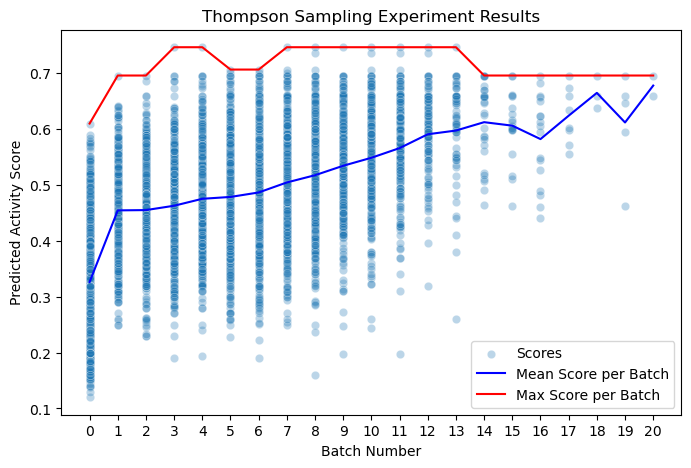

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    experiment.summarise_results(),
    x="batch",
    y="score",
    ax=ax,
    label="Scores",
    alpha=0.3,
)
sns.lineplot(
    experiment.summarise_results().groupby("batch")["score"].mean().reset_index(),
    x="batch",
    y="score",
    ax=ax,
    color="blue",
    label="Mean Score per Batch",
)
sns.lineplot(
    experiment.summarise_results().groupby("batch")["score"].max().reset_index(),
    x="batch",
    y="score",
    ax=ax,
    color="red",
    label="Max Score per Batch",
)
ax.set(
    title="Thompson Sampling Experiment Results",
    xlabel="Batch Number",
    ylabel="Predicted Activity Score",
    xticks=range(0, 21),
)
plt.show()

The mean score for the original random sample is about 0.32, the mean of the library. As we would expect, random sampling did return some active compounds. As the Thompson Sampling progresses, the mean score slowly increases until the majority of compounds being score are active. By about batch 15, the Thompson Sampling has converged on a high scoring compound.

## Comparing to full library enumeration

In [ ]:
def enumerature_entire_library() -> pd.DataFrame:
    """Enumerate the entire virtual library."""
    reaction_smarts = (
        "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]"
    )
    rxn = AllChem.ReactionFromSmarts(reaction_smarts)

    bb_types = ("aminobenzoic", "primary_amines", "carboxylic_acids")
    building_blocks = {}
    for bb in bb_types:
        mols = []
        with open(Path(f"data/{bb}_100.smi"), "r") as f:
            for line in f.readlines():
                smiles, _ = line.split()
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    mols.append(mol)
        building_blocks[bb] = mols

    product_list = []
    for i, j, k in tqdm(
        product(
            range(len(building_blocks["aminobenzoic"])),
            range(len(building_blocks["primary_amines"])),
            range(len(building_blocks["carboxylic_acids"])),
        ),
        total=len(building_blocks["aminobenzoic"])
        * len(building_blocks["primary_amines"])
        * len(building_blocks["carboxylic_acids"]),
    ):

        reagent_mol_tuple = (
            building_blocks["aminobenzoic"][i],
            building_blocks["primary_amines"][j],
            building_blocks["carboxylic_acids"][k],
        )
        products = rxn.RunReactants(reagent_mol_tuple)

        reagent_mol_tuple = (
            building_blocks["aminobenzoic"][i],
            building_blocks["primary_amines"][j],
            building_blocks["carboxylic_acids"][k],
        )
        products = rxn.RunReactants(reagent_mol_tuple)
        if products:
            Chem.SanitizeMol(products[0][0])
            product_list.append(
                {
                    "idx": f"{i}-{j}-{k}",
                    "mol": products[0][0],
                }
            )

    library = pd.DataFrame(
        product_list,
        index=[Chem.MolToSmiles(m["mol"]) for m in product_list],
    )
    library.index.name = "smiles"
    return library


full_library_start = time.time()
library = enumerature_entire_library()
library["herg_predictions"] = np.nan
batch_size = 50000
for start_idx in tqdm(range(0, len(library), batch_size)):
    end_idx = min(start_idx + batch_size, len(library))
    mols = library["mol"].iloc[start_idx:end_idx].tolist()
    fps = [list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)) for mol in mols]
    X_test = pd.DataFrame(fps, columns=[f"fp_{x}" for x in range(len(fps[0]))])
    library.iloc[start_idx:end_idx, library.columns.get_loc("herg_predictions")] = (
        ml_model.predict_proba(X_test)[:, 1]
    )
full_library_end = time.time()

100%|██████████| 20/20 [34:40<00:00, 104.00s/it]


## Evaluation of performance

In [22]:
log.info("Thompson Sampling took %.1f minutes", (ts_end - ts_start) / 60)
log.info(
    "Full library enumeration and scoring took %.1f minutes",
    (full_library_end - full_library_start) / 60,
)
log.info(
    "Thompson Sampling was %.1f times faster than full enumeration",
    (full_library_end - full_library_start) / (ts_end - ts_start),
)

[2025-11-26 19:18:17,191] INFO: Thompson Sampling took 1.0 minutes
[2025-11-26 19:18:17,192] INFO: Full library enumeration and scoring took 37.6 minutes
[2025-11-26 19:18:17,192] INFO: Thompson Sampling was 35.9 times faster than full enumeration


* Due to convergence, the Thompson Sampling involved scoring only 0.8% of the library, even with this quick scoring function, it was still 36 times faster than full enumeration. With a slower scoring function, you would expect this improvement to be even larger.
* The library is 2% actives, of the 10,000 compounds from Thompson Sampling (excluding the random sample for initialization) 49% were actives, a significant increase (a random sample of 1.3% of the library would expect 2% actives).
* Thompson Sampling found the top scoring compound from the library, 4 of the top 10, 24 of the top 50, and 51 of the top 100. It discovered 2,401 of the total 20,031 active compounds. To discover the same number of active using random sampling, we would expect to have to score 12% of the library.
* The average score of the top 100 compounds from Thompson Sampling is 0.66, only slightly lower than the average score of the top 100 compounds in the library (0.68).